## Prepare glider data for scientific analysis

The glider data has undergone a few things before coming to this stage. 


a) For 660 a thermal lag correction has already taken place on the basestation.   
b) 659 data, which had recovery problems, has been converted to scientific units.  
c) A correction was done to the T and S of the gliders to match them with surrounding water ($0.045$ is added to T of sg659, and $-0.18$ to the S of sg660.).  
d) A 2-sigma correction was applied to the T-S profiles. 


Further details in https://www.overleaf.com/8417818782tmwbmnqrfjry

**One of the main goals is to make sure that the density field does not have any overturns. So smooth just enough for that and no more.**

### Some questions to think about when doing QC: 
- How do we know some data is bad? 
- One of the main concerns in the RTQCed data are overturns. How does one deal with them? Sort them?
- What degree of further smoothing should be done to the RTQCed data? Median filters, bin averages etc? 
- Is there some objective way to determine that we are in a QC sweet spot? 
- What is the role for visual inspection? 

- What to do about the 659, which did not undergo RTQC and adjustments? 
- Do we try to apply the exact same procedures as would have been done by base station? 


In [67]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [68]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'


In [3]:
# load data that was cleaned up by Lily
data_659 = data_dir+'/data/interim/gliders/sg659_20201010/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660_20201010/CTD_660.nc'

ctd_659 = xr.load_dataset(data_659)
ctd_660 = xr.load_dataset(data_660)

### ... 
We want to do: 
https://glidertools.readthedocs.io/en/latest/quality_control.html

## For 660 

This glider underwent all the RTQC. Here we check if any more QC is needed. 

*Note*: The dive numbers are calculated differently in Lily's files, where glider dive number was assigned by loop iteration number. This does not impact anything later, since the time and other things are correct and per data point. 

### Load data

In [69]:
# load nc files directly
nc_files_660 = data_dir + '/data/raw/gliders/sg660/nc_files/*.nc'
# To see the files
#gt.load.seaglider_show_variables(nc_files_660)

In [70]:
names = [
    'ctd_depth',
    'ctd_pressure',
    'salinity',
#    'salinity_qc',
    'temperature',
#    'temperature_qc'
]
# Don't need to get the qc flags since almost all the data point are fine for 660. 

In [71]:
ds_dict = gt.load.seaglider_basestation_netCDFs(
    nc_files_660, names,
    return_merged=False,
    keep_global_attrs=False
)


DIMENSION: ctd_data_point
{longitude, ctd_pressure, latitude, ctd_depth, ctd_time, temperature, salinity}


100%|██████████| 541/541 [00:07<00:00, 72.95it/s]


In [72]:
ctd_660 = ds_dict['ctd_data_point']
ctd_660 = ctd_660.where(ctd_660.longitude<40, drop=True) # throw out data points after we stopped sampling and were just trying to get back to be picked. 

In [73]:
SA = gsw.SA_from_SP(ctd_660.salinity, ctd_660.ctd_pressure, 
                   ctd_660.longitude, ctd_660.latitude)
CT = gsw.CT_from_t(SA, ctd_660.temperature, ctd_660.ctd_pressure)


ctd_660['SA'] = SA
ctd_660['CT'] = CT
ctd_660['sigma0'] = gsw.sigma0(SA, CT)

In [74]:
ctd_660['SA'].attrs['standard_name'] = 'Absolute Salinity'
ctd_660['SA'].attrs['units'] = 'g/kg'

ctd_660['CT'].attrs['standard_name'] = 'Conservative Temperature'
ctd_660['CT'].attrs['units'] = 'deg C'
ctd_660['CT'].attrs['comment'] = ctd_660['temperature'].attrs['comment']

ctd_660['sigma0'].attrs['standard_name'] = 'Potential Density Anomaly'
ctd_660['sigma0'].attrs['units'] = 'kg/m^3'
ctd_660['sigma0'].attrs['comment'] = 'Calculated using GSW'

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/glidertools/plot.py:151: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, z, rasterized=True, **kwargs)


<AxesSubplot:xlabel='Dives', ylabel='Depth (m)'>

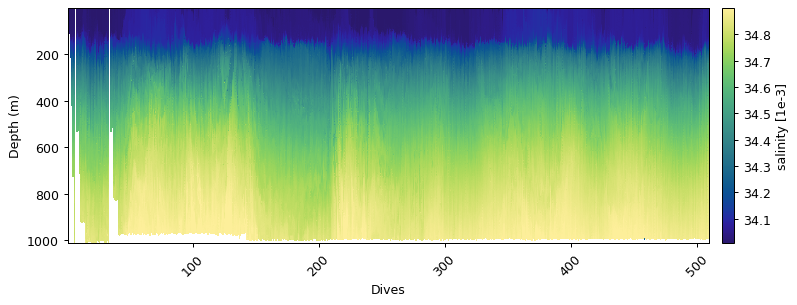

In [75]:
gt.plot(ctd_660.dives, ctd_660.ctd_pressure, ctd_660.salinity, cmap = cmo.haline, robust=True)


#### Figure out despiking choice

In [76]:
lengths =np.array([3,5,7,10, 12, 15, 17, 20, 25, 30] )
std_salt_spikes = 0.*lengths
std_temp_spikes = 0.*lengths

despiked_salt = {}
despiked_temp = {}

for i, lens  in enumerate(lengths):
    salt_base, salt_spike = gt.cleaning.despike(ctd_660.SA, window_size=lens, spike_method='median')    
    temp_base, temp_spike = gt.cleaning.despike(ctd_660.CT, window_size=lens, spike_method='median')    
    
    std_salt_spikes[i] = salt_spike.std().values
    std_temp_spikes[i] = temp_spike.std().values    
    
    despiked_salt[lens] = {'base':salt_base, 'spikes':salt_spike}
    despiked_temp[lens] = {'base':temp_base, 'spikes':temp_spike}
    


Window size of 10 seems to be the sweet spot after which the spike size does not change much. 
The increase in spike size for temperature at higher values is likely a result of the filter starting to tap into the real signal. 

Text(0.5, 0, 'Median window size')

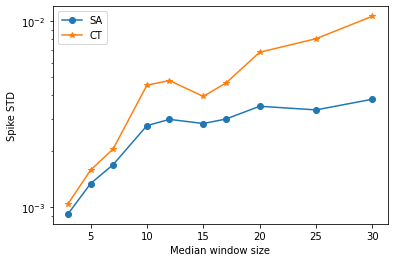

In [77]:
plt.plot(lengths, std_salt_spikes, marker='o', label='SA')
plt.plot(lengths, std_temp_spikes, marker='*', label='CT')
plt.yscale('log')
plt.legend()
plt.ylabel('Spike STD')
plt.xlabel('Median window size')

### Look at the despiking 

In [34]:
import hvplot.xarray
import panel as pn
pn.extension()

In [35]:
def profile_filtered(var = 'SA', dive_num=300): 
    
    plot = ctd_660[var].where(ctd_660.dives==dive_num, drop=True).hvplot.line(x=var, y='ctd_depth')
    
    
    temp = ctd_660
    for i in [5, 12]:
        temp[var+'_QC'] = despiked_salt[i]['base']
    
        plot = plot*temp.where(ctd_660.dives==dive_num, drop=True).hvplot.line(x=var+'_QC', y='ctd_depth')
    
    plot.opts(width=300, height=500, invert_yaxis=True, show_legend=True)
    return plot
discrete_slider2 = pn.widgets.DiscreteSlider(name='Dive number',
                                           options= list(np.arange(1,510,0.5)),
                                           value=300)

In [36]:
layout_salt_QC = pn.interact(profile_filtered, dive_num= discrete_slider2)
layout_salt_QC

Column
    [0] Column
        [0] DiscreteSlider(name='Dive number', options=[1.0, 1.5, 2.0, ...], value=300, value_throttled=300)
    [1] Row
        [0] HoloViews(Overlay, name='interactive01468')

It is a bit arbitrary, but seems like a median filter around 12 does a good job. 

### Despiking using median filters

In [78]:
filter_window = 12 # this choice made based on work above
# Do some despiking using a median filter
salt_iqr = gt.cleaning.outlier_bounds_iqr(ctd_660.SA, multiplier=1.5)
salt_base, salt_spike = gt.cleaning.despike(salt_iqr, window_size=filter_window, spike_method='median') # this is to get rid of some odd profiles

#temp_iqr = gt.cleaning.outlier_bounds_iqr(ctd_660.temperature, multiplier=2.5) # this is not a good idea for temp as it gets rid of a lot of the cold anomalies, which are real. 
temp_base, temp_spike = gt.cleaning.despike(ctd_660.CT, window_size=filter_window, spike_method='median')

In [79]:
ctd_660['SA_QC'] = salt_base
ctd_660['CT_QC'] = temp_base

In [80]:
#SA = gsw.SA_from_SP(ctd_660.SA_QC, ctd_660.ctd_pressure, 
#                   ctd_660.longitude, ctd_660.latitude)
#CT = gsw.CT_from_t(SA, ctd_660.CT_QC, ctd_660.ctd_pressure)
ctd_660['sigma0_QC'] = gsw.sigma0(ctd_660.SA_QC, ctd_660.CT_QC)

In [81]:
ctd_660['sigma0_QC'].attrs['standard_name'] = 'Potential Density Anomaly'
ctd_660['sigma0_QC'].attrs['units'] = 'kg/m^3'
ctd_660['sigma0_QC'].attrs['comment'] = 'Calculated using GSW'

In [46]:
# hvplot setup to explore individual profiles

def profile(var='SA', dive_num=300):
    
    dive_num = float(dive_num) 
    
    plot = (ctd_660.where(ctd_660.dives==dive_num, drop=True).hvplot.line(x=var, y= 'ctd_depth')  *
            ctd_660.where(ctd_660.dives==dive_num, drop=True).hvplot.line(x = var+ '_QC', y = 'ctd_depth',
                                                                        line_width=1.) )
    plot.opts(width=300, height=500, invert_yaxis=True )
    if var=='CT':
        plot.opts(xlim=(1.2, 3.5))
    elif var=='SA': 
        plot.opts(xlim=(33.9, 35))
    return plot

discrete_slider = pn.widgets.DiscreteSlider(name='Dive number',
                                           options= list(np.arange(1,510,0.5)),
                                           value=300)

layout_salt = pn.interact(profile, dive_num= discrete_slider)
layout_temp = pn.interact(profile, var='CT', dive_num= discrete_slider)
layout_dens = pn.interact(profile, var='sigma0', dive_num= discrete_slider)

In [47]:
pn.Column( pn.Row(layout_salt[1], layout_temp[1], layout_dens[1]), pn.Column('Profile explorer', layout_salt[0]))


Column
    [0] Row
        [0] Row
            [0] HoloViews(Overlay, name='interactive04962')
        [1] Row
            [0] HoloViews(Overlay, name='interactive05478')
        [2] Row
            [0] HoloViews(Overlay, name='interactive05994')
    [1] Column
        [0] Markdown(str)
        [1] Column
            [0] DiscreteSlider(name='Dive number', options=[1.0, 1.5, 2.0, ...], value=300, value_throttled=300)

The above is great. However we choose to do a little more smoothing by binning to get a vertically gridded data set on a uniform grid. This will likely also help clean some of the overturns.  

Realized that simply binning is not sufficient to get rid of all the overturns. We will use the approach of sorting the dataset based on density as well.

### Sort the data 
Let's sort the variables based on density. "Manually finish the overturn".
We will sort the density and move the corresponding T and S with it. 

In [82]:
grp = ctd_660.groupby('dives')

In [83]:
ds_dives = {}
ds_dives_nonan = {}
ds_dives_sorted = {}

dim ='ctd_data_point'

In [84]:
for k, i in grp.groups.items():
    # extract each dive and sort in depth
    ds_dives[k] = ctd_660.isel(**{dim: i}).sortby('ctd_depth') 
    # remove nans
    ds_dives_nonan[k] = ds_dives[k].where(~np.isnan(ds_dives[k].SA_QC) & ~np.isnan(ds_dives[k].CT_QC), drop=True)
    # sort by density
    # note that this has also sorted some variables that we are not looking to be sorted.
    ds_dives_sorted[k] = ds_dives_nonan[k].sortby('sigma0_QC')
    

In [133]:
ds_dives_nonan.keys()

dict_keys([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0, 30.5, 31.0, 31.5, 32.0, 32.5, 33.0, 33.5, 35.0, 35.5, 36.0, 36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42.5, 43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0, 46.5, 47.0, 47.5, 48.0, 48.5, 49.0, 49.5, 50.0, 50.5, 51.0, 51.5, 52.0, 52.5, 53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0, 58.5, 59.0, 59.5, 60.0, 60.5, 61.0, 61.5, 62.0, 62.5, 63.0, 63.5, 64.0, 64.5, 65.0, 65.5, 66.0, 66.5, 67.0, 67.5, 68.0, 68.5, 69.0, 69.5, 70.0, 70.5, 71.0, 71.5, 72.0, 72.5, 73.0, 73.5, 74.0, 74.5, 75.0, 75.5, 76.0, 76.5, 77.0, 77.5, 78.0, 78.5, 79.0, 79.5, 80.0, 80.5, 81.0, 81.5, 82.0, 82.5, 83.0, 83.5, 84.0, 84.5, 85.0, 85.5, 86.0, 86.

In [52]:
(ds_dives_nonan[120].sigma0_QC - ds_dives_sorted[120].sigma0_QC).hvplot.line()

:Curve   [index]   (sigma0_QC)

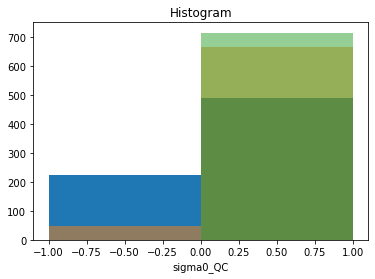

In [53]:
bins = [-1,0,1]
ds_dives_nonan[120].sigma0.diff(dim).plot.hist(bins = bins)
ds_dives_nonan[120].sigma0_QC.diff(dim).plot.hist(bins = bins, alpha=0.5);
ds_dives_sorted[120].sigma0_QC.diff(dim).plot.hist(bins = bins, alpha=0.5);

### Binning the data

Since every single glider profile is on a slightly different grid we grid all the data to a uniform grid.

In [119]:
# bin the regular data
pres_bins = np.arange(0,1001,10)
dens_gridded = gt.grid_data(ctd_660.dives, ctd_660.ctd_pressure, ctd_660.sigma0_QC, 
                           bins = pres_bins, interp_lim=0)
temp_gridded = gt.grid_data(ctd_660.dives, ctd_660.ctd_pressure, ctd_660.CT_QC, 
                           bins = pres_bins, interp_lim=0)
salt_gridded = gt.grid_data(ctd_660.dives, ctd_660.ctd_pressure, ctd_660.SA_QC, 
                           bins = pres_bins, interp_lim=0)

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.69
Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.69
Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.69


In [120]:
# bin the sorted data 
# For this we need to do these loops since we had split the data into individual dives. 
k=1.
dens_sorted_gridded = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_sorted[k].sigma0_QC, 
                           bins = pres_bins, verbose=False, interp_lim=0)
temp_sorted_gridded = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_sorted[k].CT_QC, 
                           bins = pres_bins, verbose=False, interp_lim=0)
salt_sorted_gridded = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_sorted[k].SA_QC, 
                           bins = pres_bins, verbose=False, interp_lim=0)

time_sorted_gridded = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_nonan[k].ctd_time, 
                           bins = pres_bins, verbose=False, interp_lim=0)
lat_sorted_gridded = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_nonan[k].latitude, 
                           bins = pres_bins, verbose=False, interp_lim=0)
lon_sorted_gridded = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_nonan[k].longitude, 
                           bins = pres_bins, verbose=False, interp_lim=0)


for k in ds_dives_sorted.keys():
    if len(ds_dives_nonan[k].ctd_data_point)>0:
        temp = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_sorted[k].sigma0_QC, 
                           bins = pres_bins, verbose=False, interp_lim=0);
    
        dens_sorted_gridded = xr.concat([dens_sorted_gridded, temp], dim='dives')
        
        temp = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_sorted[k].CT_QC, 
                           bins = pres_bins, verbose=False, interp_lim=0);
    
        temp_sorted_gridded = xr.concat([temp_sorted_gridded, temp], dim='dives')
        
        temp = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_sorted[k].SA_QC, 
                           bins = pres_bins, verbose=False, interp_lim=0);
    
        salt_sorted_gridded = xr.concat([salt_sorted_gridded, temp], dim='dives')
        
        temp = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_nonan[k].ctd_time, 
                           bins = pres_bins, verbose=False, interp_lim=0);
    
        time_sorted_gridded = xr.concat([time_sorted_gridded, temp], dim='dives')
        
        temp = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_nonan[k].latitude, 
                           bins = pres_bins, verbose=False, interp_lim=0);
    
        lat_sorted_gridded = xr.concat([lat_sorted_gridded, temp], dim='dives')
        
        temp = gt.grid_data(ds_dives_nonan[k].dives, ds_dives_nonan[k].ctd_pressure, ds_dives_nonan[k].longitude, 
                           bins = pres_bins, verbose=False, interp_lim=0);
    
        lon_sorted_gridded = xr.concat([lon_sorted_gridded, temp], dim='dives')
        
# Throw away the first column since it has been added twice. 
dens_sorted_gridded = dens_sorted_gridded[:,1:]
temp_sorted_gridded = temp_sorted_gridded[:,1:]
salt_sorted_gridded = salt_sorted_gridded[:,1:]
time_sorted_gridded = time_sorted_gridded[:,1:]
lat_sorted_gridded  = lat_sorted_gridded[:,1:]
lon_sorted_gridded  = lon_sorted_gridded[:,1:]

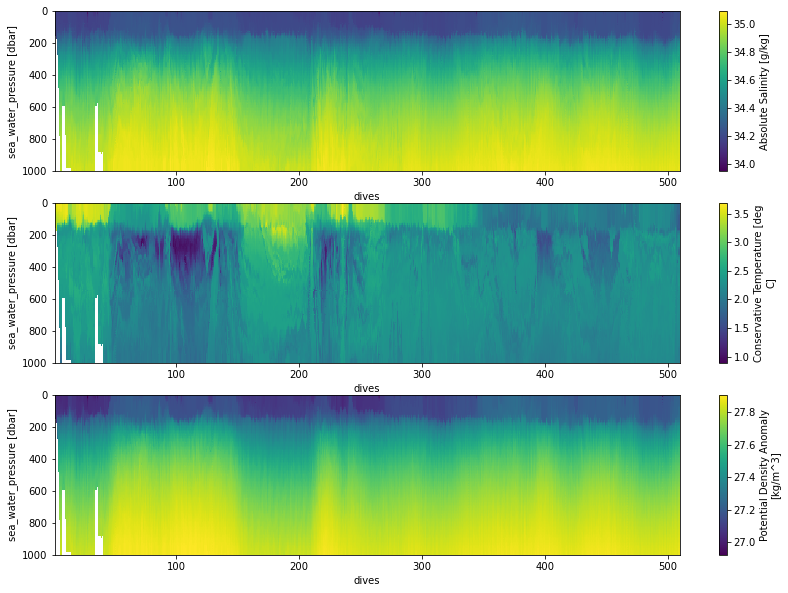

In [57]:
plt.figure(figsize=(14, 10))

plt.subplot(311)
salt_gridded.plot()
plt.gca().invert_yaxis()

plt.subplot(312)
temp_gridded.plot()
plt.gca().invert_yaxis()

plt.subplot(313)
dens_gridded.plot()
plt.gca().invert_yaxis()

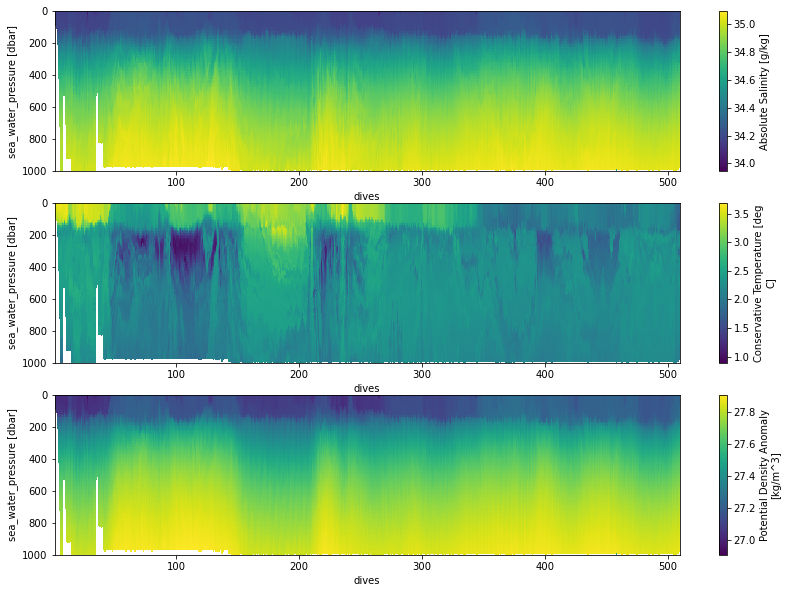

In [142]:
plt.figure(figsize=(14, 10))

plt.subplot(311)
salt_sorted_gridded.plot()
plt.gca().invert_yaxis()

plt.subplot(312)
temp_sorted_gridded.plot()
plt.gca().invert_yaxis()

plt.subplot(313)
dens_sorted_gridded.plot()
plt.gca().invert_yaxis()

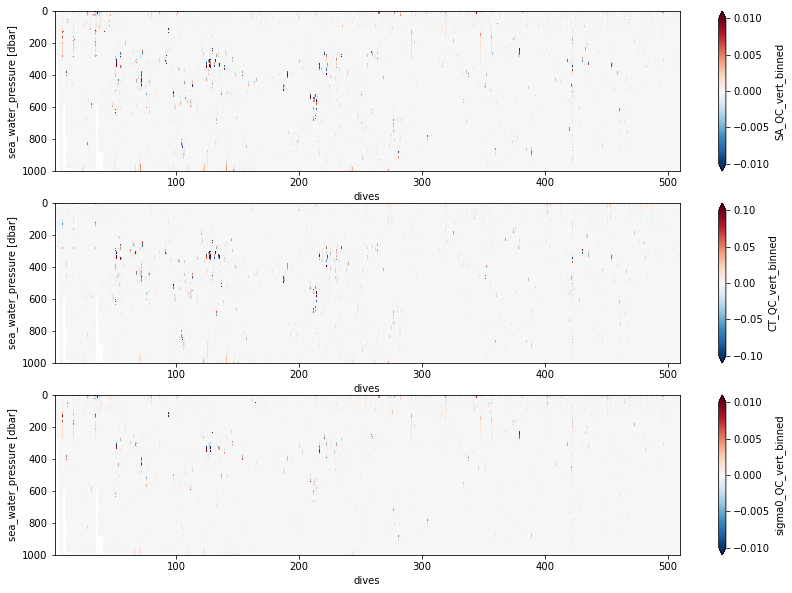

In [59]:
plt.figure(figsize=(14, 10))

plt.subplot(311)
(salt_sorted_gridded - salt_gridded).plot(vmin=-0.01)
plt.gca().invert_yaxis()

plt.subplot(312)
(temp_sorted_gridded - temp_gridded).plot(vmin=-0.1)
plt.gca().invert_yaxis()

plt.subplot(313)
(dens_sorted_gridded - dens_gridded).plot(vmin=-0.01)
plt.gca().invert_yaxis()

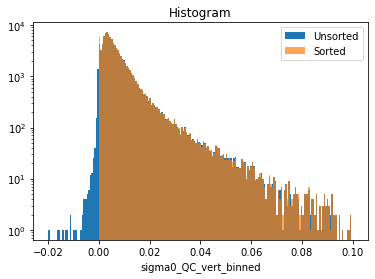

In [143]:
bins = bins=np.linspace(-0.02, 0.1, 200)
dens_gridded.diff('ctd_pressure').plot.hist(bins=bins, label='Unsorted')
dens_sorted_gridded.diff('ctd_pressure').plot.hist(bins=bins, label='Sorted', alpha=0.7)
plt.legend()
plt.yscale('log')

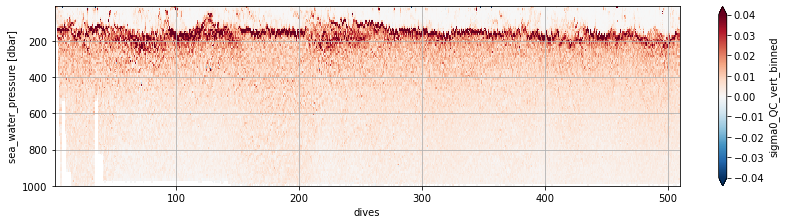

In [144]:
plt.figure(figsize=(14, 3.3))
dens_gridded.diff('ctd_pressure').plot(vmin=-0.04)
plt.gca().invert_yaxis()
plt.grid()

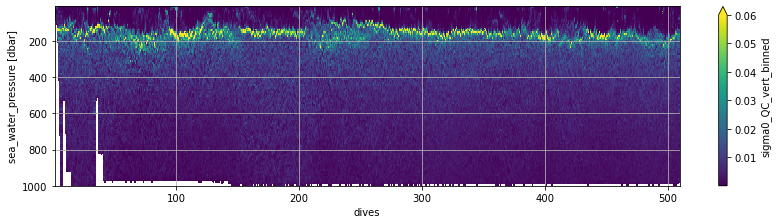

In [145]:
# As expected sorting makes N2 purely positive. 

plt.figure(figsize=(14, 3.3))

dens_sorted_gridded.diff('ctd_pressure').plot(vmax=0.06)
plt.gca().invert_yaxis()
plt.grid()

In [146]:
ds_660_grid = xr.merge([dens_sorted_gridded.rename('sigma0'), 
                        salt_sorted_gridded.rename('SA'), 
                        temp_sorted_gridded.rename('CT'),
                        time_sorted_gridded.rename('time'), 
                        lat_sorted_gridded.rename('latitude'), 
                        lon_sorted_gridded.rename('longitude')])

In [147]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 27.03 27.02 27.02 ... nan nan
    SA            (ctd_pressure, dives) float64 34.15 34.15 34.15 ... nan nan
    CT            (ctd_pressure, dives) float64 3.59 3.618 3.617 ... nan nan nan
    time          (ctd_pressure, dives) float64 1.557e+09 1.557e+09 ... nan nan
    latitude      (ctd_pressure, dives) float64 -51.5 -51.49 -51.48 ... nan nan
    longitude     (ctd_pressure, dives) float64 30.03 30.03 30.05 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076215615, 35.65218567611555]

In [148]:
ds_660_grid.to_netcdf('data/ctd_660_vert_binned_29_june_2021.nc')

### For 659

659 was unable to get processed by the basestation. So the data has not gone through the same QC and adjustments as 660. So then the question is what to do with it: 
- Check what happens at the dive around when the glider stopped producing data, to see if there is a major change in properties (like a shift). 
- Compare against the closest profile of the 660 glider or the float.

---

- Maybe doing the QC offline here would be sufficient. 
- Maybe there is a way to figure out how to run the glider through the basestation processing scripts. 

In [5]:
dives = ctd_659.dives
pres = ctd_659.pressure
salt = ctd_659.salinity
temp = ctd_659.temperature

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/glidertools/plot.py:151: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, z, rasterized=True, **kwargs)


Text(0.5, 1.0, 'Original Data')

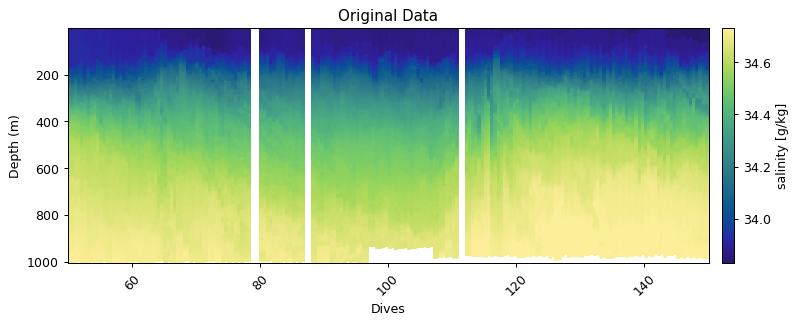

In [11]:
gt.plot(dives, pres, salt, cmap=cmo.haline, robust=True)
plt.xlim(50, 150)
plt.title('Original Data')

In [8]:
salt_iqr = gt.cleaning.outlier_bounds_iqr(salt, multiplier=1.5)
salt_std = gt.cleaning.outlier_bounds_std(salt, multiplier=1.5)

Text(0.5, 1.0, 'STD Data')

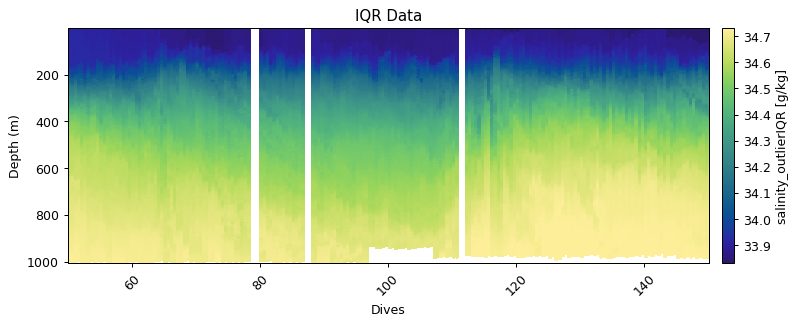

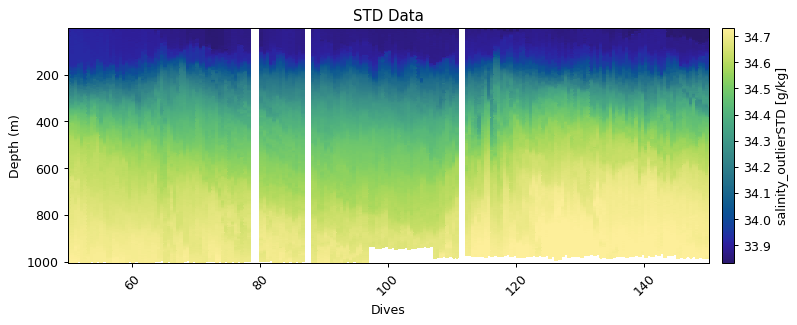

In [12]:
gt.plot(dives, pres, salt_iqr, cmap=cmo.haline, robust=True)
plt.xlim(50, 150)
plt.title('IQR Data')

gt.plot(dives, pres, salt_std, cmap=cmo.haline, robust=True)
plt.xlim(50, 150)
plt.title('STD Data')

In [13]:
salt_base, salt_spike = gt.cleaning.despike(salt, window_size=5, spike_method='median')


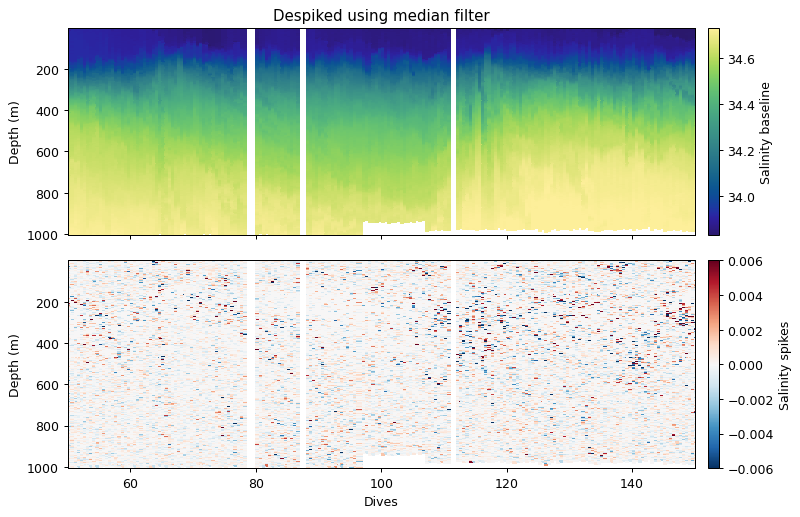

In [16]:
fig, ax = plt.subplots(2, 1, figsize=[9, 6], sharex=True, dpi=90)

gt.plot(dives, pres, salt_base, cmap=cmo.haline, ax=ax[0])
ax[0].set_title('Despiked using median filter')
ax[0].cb.set_label('Salinity baseline')
ax[0].set_xlim(50,150)
ax[0].set_xlabel('')

gt.plot(dives, pres, salt_spike, cmap="RdBu_r", vmin=-6e-3, vmax=6e-3, ax=ax[1])
ax[1].cb.set_label('Salinity spikes')
ax[1].set_xlim(50,150)

plt.xticks(rotation=0)
plt.show()


In [22]:
salt_base

<xarray.DataArray 'salinity_baseline' (ctd_data_point: 1363330)>
array([        nan,         nan,         nan, ..., 33.8916893 ,
       33.89167527,         nan])
Dimensions without coordinates: ctd_data_point
Attributes:
    units:          g/kg
    standard_name:  Absolute Salinity
    history:        [2021-06-23 15:37:18] (v2021.3) glidertools.cleaning.desp...

In [67]:
salt_rollavg = gt.cleaning.rolling_window(salt, np.mean, window=5)
salt_rollavg_median = gt.cleaning.rolling_window(salt_base, np.mean, window=5)


In [64]:
salt_rollavg

<xarray.DataArray 'salinity_rollwin' (ctd_data_point: 1363330)>
array([nan, nan, nan, ..., nan, nan, nan])
Dimensions without coordinates: ctd_data_point
Attributes:
    units:          g/kg
    standard_name:  Absolute Salinity
    history:        [2021-06-23 17:30:37] (v2021.3) glidertools.cleaning.roll...

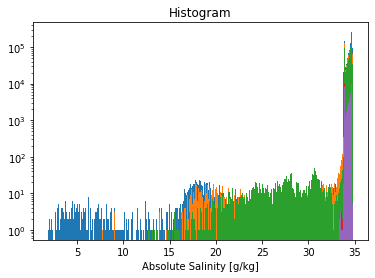

In [82]:
salt.plot.hist(bins=500);
salt_base.plot.hist(bins=500);
salt_rollavg.plot.hist(bins=500);
salt_iqr.plot.hist(bins=500);
salt_std.plot.hist(bins=500);
plt.yscale('log')

In [29]:
import hvplot.xarray

In [32]:
%matplotlib inline


<xarray.DataArray 'salinity' (ctd_data_point: 1363330)>
array([        nan,         nan,         nan, ..., 33.89170333,
       33.89167527,         nan])
Dimensions without coordinates: ctd_data_point
Attributes:
    units:          g/kg
    standard_name:  Absolute Salinity

In [68]:
dive_num = 300


(salt.where(dives==dive_num, drop=True).hvplot.line(x='salinity') * 
 salt_base.where(dives==dive_num, drop=True).hvplot.line() *
 salt_rollavg.where(dives==dive_num, drop=True).hvplot.line() * 
 salt_rollavg_median.where(dives==dive_num, drop=True).hvplot.line())


:Overlay
   .Curve.I   :Curve   [index]   (salinity)
   .Curve.II  :Curve   [index]   (salinity_baseline)
   .Curve.III :Curve   [index]   (salinity_rollwin)
   .Curve.IV  :Curve   [index]   (salinity_baseline_rollwin)

In [80]:

def glider_prof(dive_num=)
ctd_659.where(dives==dive_num, drop=True).hvplot(x='salinity', y='pressure',
                                                 width=300, height=600, flip_yaxis=True)

:Curve   [salinity]   (pressure)